<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/caching_testv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler
from collections import OrderedDict, defaultdict, Counter
from google.colab import drive
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [10, 8]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
test_set = np.load('drive/My Drive/cache_test.npy')

In [0]:
rand_sample = pd.read_csv('drive/My Drive/rand_sample.csv', index_col=0)
ixs = rand_sample.index.values
content_names = ixs

In [0]:
content_names

array([11570, 77306, 74655, ..., 32992, 75535, 75476])

In [0]:
# constants
num_contents = len(content_names)
sim_length = 7 * 4 # if sim length is not a multiple of 7, the debug pred time series will break!
seed = 123

In [0]:
class ContentStore:
    def __init__(self, size):
        self.size = size
        self.hits = 0
        self.misses = 0

    def add(self, item):
        pass

    def get_helper(self, item):
        # function is overriden for custom get implementations
        # in derived classes
        pass

    def get(self, item):
        item = self.get_helper(item)
        if item != None:
            self.hits += 1
        else:
            self.misses += 1
        return item

## Traditional Caching Algorithms

### LRU

In [0]:
class LruContentStore(ContentStore):
    def __init__(self, size):
        super().__init__(size)
        self.store = OrderedDict()
        self.start_counting = False

    def add(self, item):
        # returns can cache ?, victim
        victim = None
        if item in self.store or self.size <= 0:
            return False, victim
        if self.size:
            if(len(self.store) == self.size):
                # remove top element (least recent element)
                victim, _ = self.store.popitem(last=False)
            self.store[item] = item
            return True, victim

    def get_helper(self, item):
        try:
            cached_item = self.store.pop(item)
            # re-insert content to maintain lru-order
            self.store[item] = cached_item
            return cached_item
        except:
            return None

### Random

In [0]:
class RandomContentStore(ContentStore):
    def __init__(self, size):
        super().__init__(size)
        self.rng = np.random.RandomState(123)
        self.size = size
        self.store = {}

    def add(self, item):
        if self.size:
            if len(self.store) == self.size:
                self.store.pop(self.rng.choice(list(self.store.keys())))
            self.store[item] = item
    
    def get_helper(self, item):
        try:
            cached_item = self.store[item]
            return cached_item
        except:
            return None

## Machine Learning Models for Caching

### Multi-Day Predictor with BootStrap 

In [0]:
class PretrainedCNNContentStore(ContentStore):
    def __init__(self, size, model, online=False):
        super().__init__(size)

        # bootstrapping
        self.bootstrap = LruContentStore(size)
        self.bootstrap_period = 7
        self.bootstrapping = True

        # constants
        self.pred_length = 7
        self.window_length = 7
        self.num_features = 11
        self.reqs_per_day = 500000
        self.num_portals = 10

        # counter
        self.req_counter = 0

        # ml-related
        self.model = load_model(model)
        self.scaler = MinMaxScaler()

        # stats
        self.history = OrderedDict()

        # ranks
        self.ranking = OrderedDict()

        # cache
        self.store = OrderedDict()

        # data
        self.portals = np.load('drive/My Drive/portals_dict.npy').item()
        
        # debug
        self.pred_time_series = {}
        for name in content_names:
            self.pred_time_series[name] = np.zeros((sim_length))
        #
    
    def get_curr_day(self):
        return (self.req_counter - 1) // self.reqs_per_day
    
    def get_curr_timestep(self):
        return self.get_curr_day() % self.pred_length

    def get_portal_key(self, item):
        # extract index from item name ex: from serverA/12 to 12
        if isinstance(item, str):
            start_ix = item.rfind('/') + 1
            return int(item[start_ix:])
        else:
            return item
    
    # add item to cache if more popular
    def add(self, item):
        victim = None
        if self.bootstrapping:
            return self.bootstrap.add(item)
        else:
            if item in self.store or self.size <= 0:
                return False, victim
            if self.size:
                if len(self.store) == self.size:
                    min_key, min_rank = self.get_least_popular()
                    # replace if curr item more popular than least popular in cache
                    if min_rank != None and min_rank < self.ranking[item][self.get_curr_timestep()]:
                        victim = min_key
                        self.store.pop(victim)
                        self.store[item] = item
                        return True, victim
                    else:
                        return False, victim
                else:
                    self.store[item] = item
                    return True, victim

    def get_least_popular(self):
        min_item = None
        min_rank = None
        for item in self.store.keys():
            if min_item == None or self.ranking[item][self.get_curr_timestep()] < min_rank:
                min_rank = self.ranking[item][self.get_curr_timestep()]
                min_item = item
        return min_item, min_rank

    def update_rankings(self):
        self.bootstrapping = False
        
        # init npy arrays
        agg_data = np.zeros((len(self.history.keys()), self.window_length))
        portal_data = np.zeros((len(self.history.keys()), self.window_length, self.num_portals))
                
        for ix, key in enumerate(self.history.keys()):
            agg_data[ix] = self.history[key]
            portal_key = self.get_portal_key(key)
            if portal_key in self.portals:
                portal_encoding = np.tile(self.portals[portal_key], (self.window_length, 1))
            else:
                portal_encoding = np.tile(np.zeros((self.num_portals)), (self.window_length, 1))
            portal_data[ix] = portal_encoding
             
        # log and normalize data
        agg_data = np.log1p(agg_data)
        agg_data = self.scaler.fit_transform(agg_data)
        
        agg_data = agg_data.reshape(-1, self.window_length, 1)

        # add portal features
        agg_data = np.concatenate((agg_data, portal_data), axis=2)
        
        # make preds

        predictions = self.predict_sequence(agg_data)  # update rankings                
        rankings = predictions[:, :, 0]
        
        # reset old ranking
        self.ranking = OrderedDict()

        # map preds to content types
        for i, key in enumerate(self.history.keys()):
            self.ranking[key] = rankings[i]
            # debug
            self.pred_time_series[key][self.get_curr_day(): self.get_curr_day() + self.pred_length] = self.ranking[key]
            #
        # reset stats
        for key in self.history.keys():
            self.history[key] = np.zeros((self.window_length))

    def get_helper(self, item):
        self.req_counter += 1
        if self.req_counter != 1 and (self.req_counter-1) % (self.reqs_per_day * self.window_length) == 0:
            # if first update, copy over cache from bootstrap
            if self.req_counter - 1 == self.reqs_per_day * self.window_length:
                self.store = self.bootstrap.store
            # print('start updating rankings')
            self.update_rankings()
            # print('finished updating rankings')
        if item not in self.history:
            self.history[item] = np.zeros(self.window_length)
        if item not in self.ranking:
            self.ranking[item] = np.zeros(self.pred_length)
        # update history
        self.history[item][self.get_curr_timestep()] += 1
        try:
            if self.bootstrapping:
                cached_item = self.bootstrap.get(item)
            else:
                cached_item = self.store[item]
            return cached_item
        except:
            return None

    def predict_sequence(self, input_sequence):
        history_sequence = input_sequence.copy()
        # initialize output (pred_steps time steps)
        pred_sequence = np.zeros((input_sequence.shape[0], self.pred_length, self.num_features))
        for i in range(self.pred_length):
            # record next time step prediction (last time step of model output)
            last_step_pred = self.model.predict(history_sequence)[:, -1, :self.num_features]
            pred_sequence[:, i, :self.num_features] = last_step_pred
            # add the next time step prediction to the history sequence
            history_sequence = np.concatenate([history_sequence, last_step_pred.reshape(-1, 1, self.num_features)], axis=1)
        return pred_sequence

### Init Content Stores

In [0]:
cache_size = int(0.001 * test_set.shape[0])
lru = LruContentStore(cache_size)
rand = RandomContentStore(cache_size)
cnn = PretrainedCNNContentStore(cache_size, 'drive/My Drive/opt_reshaped_simple_conv_with_portals.h5')
cses = [cnn, lru]

### Initialize Statistical Baselines with Training Set

### Run Tests with Test Set

In [0]:
# Simulation
sim_stats = {}
for name in content_names:
    sim_stats[name] = np.zeros((sim_length))

for cs in cses:
    np.random.seed(seed)
    for i in range(sim_length):
        # get num requests for each content type for day i
        daily_reqs = test_set[:, i]
        # repeat indexes based on the number of times they appear
        flat_daily_reqs = np.repeat(content_names, 
                                    daily_reqs.astype('int'), 
                                    axis=0)
        np.random.shuffle(flat_daily_reqs)
        for req in flat_daily_reqs:
            sim_stats[req][i] += 1
            if cs.get(req) == None:
                cs.add(req)
        print(i)
    print(cs.hits/(cs.hits+cs.misses))

0
1
2
3
4
5
6
start updating rankings
finished updating rankings
7
8
9
10
11
12
13
start updating rankings
finished updating rankings
14
15
16
17
18
19
20
start updating rankings
finished updating rankings
21
22
23
24
25
26
27
0.32987916306611326
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0.3122750226296409


In [0]:
np_sim_stats = np.zeros((len(content_names), sim_length))
np_pred_stats = np.zeros((len(content_names), sim_length))
for i, name in enumerate(content_names):
    if name in sim_stats:
        np_sim_stats[i] = sim_stats[name]
    else:
        np_sim_stats[i] = np.zeros((sim_length))
    if name in cses[0].pred_time_series:
        np_pred_stats[i] = cses[0].pred_time_series[name]
    else:
        np_pred_stats[i] = np.zeros((sim_length))
norm_np_sim_stats = MinMaxScaler().fit_transform(np.log1p(np_sim_stats))

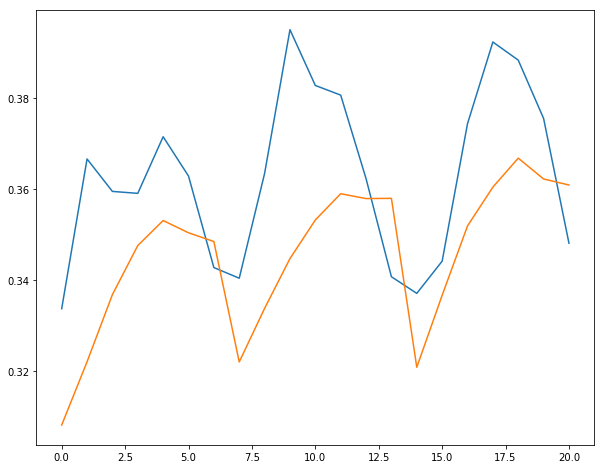

In [0]:
ix = 30
plt.plot(norm_np_sim_stats[ix][7:])
plt.plot(np_pred_stats[ix][7:])